# Inversion with a configuration file

In this notebook we show how to use a configuration file to run Hazel in different situations for inverting Stokes profiles.

## On-disk inversions
Let's first a set of observations obtained from the GREGOR telescope as example. The observations consisted of a scan of an active region in which filaments are seen when observed in the core of the He I 10830 A line. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import hazel
import h5py
import scipy.io as io
print(hazel.__version__)
label = ['I', 'Q', 'U', 'V']

2018.9.22


First read the observations and do some plots. The wavelength axis in the save file is given in displacement with respect to some reference wavelength, in this case 10830.0911 A.

dict_keys(['heperf', 'lambda'])
210


/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


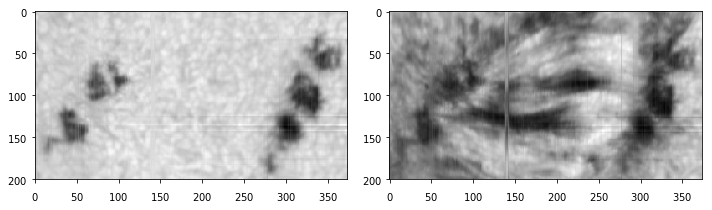

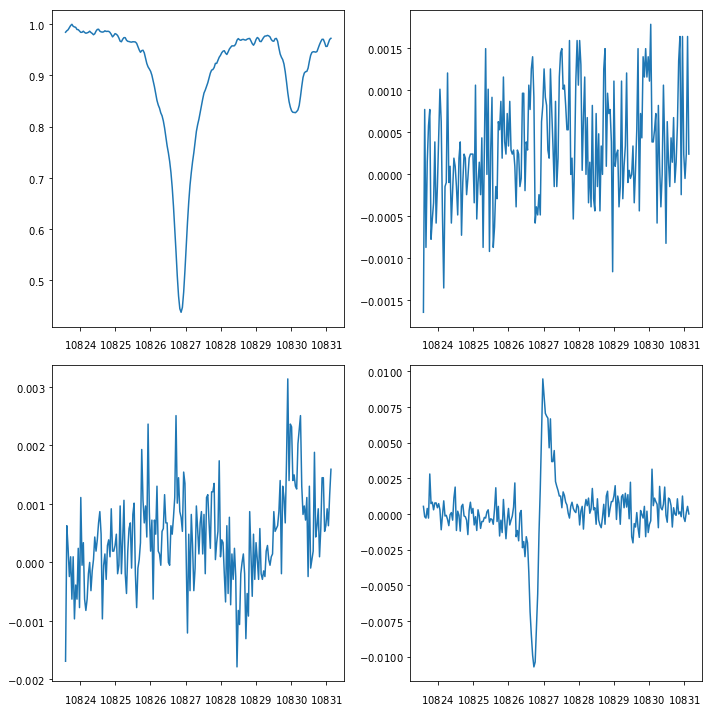

In [2]:
tmp = io.readsav('/scratch/Dropbox/test/test_hazel2/orozco/gregor_spot.sav')
print(tmp.keys())
f, ax = pl.subplots(nrows=1, ncols=2, figsize=(10,6))
ax[0].imshow(tmp['heperf'][:,0,:,0])
ax[1].imshow(tmp['heperf'][:,0,:,181])

f, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
stokes = np.zeros((4,210))
stokes[0,:] = tmp['heperf'][160,0,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
stokes[1,:] = tmp['heperf'][160,1,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
stokes[2,:] = tmp['heperf'][160,2,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
stokes[3,:] = tmp['heperf'][160,3,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
ax[0,0].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[0,:])
ax[0,1].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[1,:])
ax[1,0].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[2,:])
ax[1,1].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[3,:])

wvl = tmp['lambda'][0:-40]
stokes = stokes[:,:]
n_lambda = len(wvl)
print(n_lambda)

Let's compute a very rough estimation of the noise standard deviation:

In [3]:
noise = np.std(stokes[1,0:20])

Now we save 1D files for the inversion. You can use the tools provided by the code, which makes things really easy:

In [4]:
tmp = hazel.tools.File_observation(mode='single')
tmp.set_size(n_lambda=n_lambda, n_pixel=1)
print(tmp.obs['stokes'].shape)
tmp.obs['wavelength'] = wvl+10830.0911    # The wavelength in the file is given wrt the blue component but this is wrong 
tmp.obs['stokes'][0,:,:] = stokes.T
tmp.obs['sigma'] = noise*np.ones((n_lambda,4))
tmp.obs['los'][0,:] = np.array([0.0,0.0,90.0])
tmp.obs['boundary'][:] = 0.0
tmp.obs['boundary'][0,:,0] = 1.0
tmp.obs['weights'][:] = 1.0
tmp.save('10830_spot')

(1, 210, 4)
Saving wavelength file : 10830_spot.wavelength
Saving weights file : 10830_spot.weights
Saving 1D Stokes file : 10830_spot.1d


You can also do it by hand, which is not so easy to understand:

In [5]:
np.savetxt('10830_spot.wavelength', wvl+10830.0911, header='lambda')

f = open('10830_spot.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_lambda):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

f = open('10830_spot.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'0.0 0.0 90.0\n')
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'1.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise*np.ones((4,n_lambda))])
np.savetxt(f, tmp.T)
f.close()

In [6]:
%cat 10830_spot.1d

# LOS theta_LOS, phi_LOS, gamma_LOS
0.0 0.0 90.0

# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
1.0 0.0 0.0 0.0

# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV
9.844778180122375488e-01 -1.641324721276760101e-03 -1.689598895609378815e-03 5.310168489813804626e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04
9.873363971710205078e-01 7.723881280981004238e-04 6.275653140619397163e-04 -1.930970320245251060e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04
9.892690181732177734e-01 -8.689365931786596775e-04 2.413712936686351895e-04 -2.896455407608300447e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04
9.933860301971435547e-01 1.448227703804150224e-04 -2.413712936686351895e-04 3.861940640490502119e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04
9.975462555885314

So we are now ready for the inversion. Let's print first the configuration file and then do a simple inversion for a 1D input file. You can see that we are including two atmospheres, a photosphere to explain the Si I line and a chromosphere to explain the He I multiplet. We also give some rough intervals for the parameters.

Let's also generate a couple of standard atmospheres which will be used as input in the configuration file:

In [7]:
tmp = hazel.tools.File_photosphere(mode='single')
tmp.set_default(n_pixel=1, default='hsra')
tmp.save('photospheres/init_spot')

tmp = hazel.tools.File_chromosphere(mode='single')
tmp.set_default(n_pixel=1, default='disk')
tmp.save('chromospheres/init_spot')

Setting HSRA photosphere
Saving photospheric 1D model : photospheres/init_spot.1d
Setting standard chromosphere
Saving chromospheric 1D model : chromospheres/init_spot.1d


In [8]:
%cat conf_spot.ini

# Hazel configuration File

[Working mode]
Output file = output.h5
Number of cycles = 2

# Topology
# Always photosphere and then chromosphere
# Photospheres are only allowed to be added with a filling factor
# Atmospheres share a filling factor if they are in parenthesis
# Atmospheres are one after the other with the -> operator
# Atmosphere 1 = ph2 -> ch1 -> ch2

[Spectral regions]
    [[Region 1]]
    Name = spec1
    Topology = ph1 -> ch1
    Stokes weights = 1.0, 1.0, 1.0, 1.0
    LOS = 0.0, 0.0, 90.0
    Boundary condition = 1.0, 0.0, 0.0, 0.0       # I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
    Wavelength file = '10830_spot.wavelength'
    Wavelength weight file = '10830_spot.weights'
    Observations file = '10830_spot.1d'    
    Weights Stokes I = 1.0, 0.0, 0.0, 0.0
    Weights Stokes Q = 0.0, 10.0, 0.0, 0.0
    Weights Stokes U = 0.0, 10.0, 0.0, 0.0
    Weights Stokes V = 0.0, 10.0, 0.0, 0.0
    Mask file = None

[Atmospheres]

    [[Chromosphere 1]]
    Name = ch1    

In [9]:
mod = hazel.Model('conf_spot.ini', working_mode='inversion', verbose=3)
mod.read_observation()
mod.open_output()
mod.invert()
mod.write_output()
mod.close_output()

2018-10-24 09:53:51,511 - Using configuration from file : conf_spot.ini
2018-10-24 09:53:51,515 - Adding spectral region spec1
2018-10-24 09:53:51,516 -   - Reading wavelength axis from 10830_spot.wavelength
2018-10-24 09:53:51,521 -   - Reading wavelength weights from 10830_spot.weights
2018-10-24 09:53:51,526 -   - Using observations from 10830_spot.1d
2018-10-24 09:53:51,527 -   - No mask for pixels
2018-10-24 09:53:51,528 -   - No instrumental profile
2018-10-24 09:53:51,529 -   - Using LOS ['0.0', '0.0', '90.0']
2018-10-24 09:53:51,530 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-10-24 09:53:51,531 - Using 2 cycles
2018-10-24 09:53:51,532 - Not using randomizations
2018-10-24 09:53:51,533 - Adding atmospheres
2018-10-24 09:53:51,533 -   - New available chromosphere : ch1
2018-10-24 09:53:51,534 -     * Adding line : 10830
2018-10-24 09:53:51,535 -     * Magnetic field reference frame : vertical
2018-10-24 09:53:51,536 -     * Reading 1D model chromospheres/init

     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.275    -1.514    10.214     1.000     0.000


2018-10-24 09:53:55,248 -   * Optimal lambda: 0.0031329840216438656
2018-10-24 09:53:55,856 - It: 1 - chi2: 219.67708243514014 - lambda: 0.0031329840216438656 - rel: -1.0747759933352057


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.241    -4.468    11.571     1.000     0.000


2018-10-24 09:53:56,653 -   * Optimal lambda: 0.005397943999573633
2018-10-24 09:53:57,300 - It: 2 - chi2: 88.44700424554424 - lambda: 0.005397943999573633 - rel: -0.8518001925996291


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.290    -4.669     9.299     1.000     0.000


2018-10-24 09:53:58,804 -   * Optimal lambda: 0.000539794399957363
2018-10-24 09:53:59,463 - It: 3 - chi2: 62.940986344325864 - lambda: 0.000539794399957363 - rel: -0.33696223593214225


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.292    -4.969     9.963     1.000     0.000


2018-10-24 09:54:00,704 -   * Optimal lambda: 0.0005397943999573629
2018-10-24 09:54:01,353 - It: 4 - chi2: 62.366510912066666 - lambda: 0.0005397943999573629 - rel: -0.009169051251319154


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.291    -4.884    10.037     1.000     0.000


2018-10-24 09:54:02,065 -   * Optimal lambda: 0.0020434336502263206
2018-10-24 09:54:02,718 - It: 5 - chi2: 62.34719752764511 - lambda: 0.0020434336502263206 - rel: -0.00030972352058465804


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.291    -4.873    10.077     1.000     0.000


2018-10-24 09:54:04,091 -   * Optimal lambda: 6.461904582147022
2018-10-24 09:54:04,627 - It: 6 - chi2: 62.34706661811411 - lambda: 6.461904582147022 - rel: -2.0996880953866914e-06


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.291    -4.872    10.078     1.000     0.000


2018-10-24 09:54:05,174 - -------------
2018-10-24 09:54:05,175 -   Cycle 1  
2018-10-24 09:54:05,176 -   Weights for region spec1 : SI=0.0 - SQ=10.0 - SU=10.0 - SV=10.0
2018-10-24 09:54:05,176 - -------------
2018-10-24 09:54:05,177 - Free parameters for ch1
2018-10-24 09:54:05,178 -   - Bx with 1 node
2018-10-24 09:54:05,179 -   - By with 1 node
2018-10-24 09:54:05,180 -   - Bz with 1 node
2018-10-24 09:54:05,181 - Free parameters for ph1
2018-10-24 09:54:05,182 -   - Bz with 1 node
2018-10-24 09:54:07,470 -   * Optimal lambda: 0.6461904582147021
2018-10-24 09:54:08,172 - It: 0 - chi2: 16.730145131714785 - lambda: 0.6461904582147021 - rel: -1.153731156599563


     Bx        By        Bz        tau       v       deltav      beta      a
  -0.014     0.014   -22.413     0.291    -4.872    10.078     1.000     0.000


2018-10-24 09:54:09,330 -   * Optimal lambda: 0.26610281324782875
2018-10-24 09:54:10,033 - It: 1 - chi2: 13.42091457596078 - lambda: 0.26610281324782875 - rel: -0.21951006616935417


     Bx        By        Bz        tau       v       deltav      beta      a
 216.671  -499.982   -32.376     0.291    -4.872    10.078     1.000     0.000


2018-10-24 09:54:10,886 -   * Optimal lambda: 0.7340985960149292
2018-10-24 09:54:11,585 - It: 2 - chi2: 15.868097531285427 - lambda: 0.7340985960149292 - rel: 0.16710587208362726


     Bx        By        Bz        tau       v       deltav      beta      a
 255.481   500.000   -33.334     0.291    -4.872    10.078     1.000     0.000


2018-10-24 09:54:12,249 -   * Optimal lambda: 9.907551591772469
2018-10-24 09:54:12,954 - It: 3 - chi2: 15.208039400657768 - lambda: 9.907551591772469 - rel: -0.042480063212051604


     Bx        By        Bz        tau       v       deltav      beta      a
 256.706   500.000   -37.089     0.291    -4.872    10.078     1.000     0.000


2018-10-24 09:54:13,451 -   * Optimal lambda: 320.00667607585524
2018-10-24 09:54:14,157 - It: 4 - chi2: 15.206620836057217 - lambda: 320.00667607585524 - rel: -9.328163389035902e-05


     Bx        By        Bz        tau       v       deltav      beta      a
 256.686   500.000   -37.035     0.291    -4.872    10.078     1.000     0.000


NWe see that we found a solution with a relatively good $\chi^2$ and now let's analyze the results. For your specific case, you probably need some trial and error on the Stokes weights and range of parameters to find a reliable solution.

(npix,nrand,ncycle,nstokes,nlambda) -> (1, 1, 2, 4, 210)


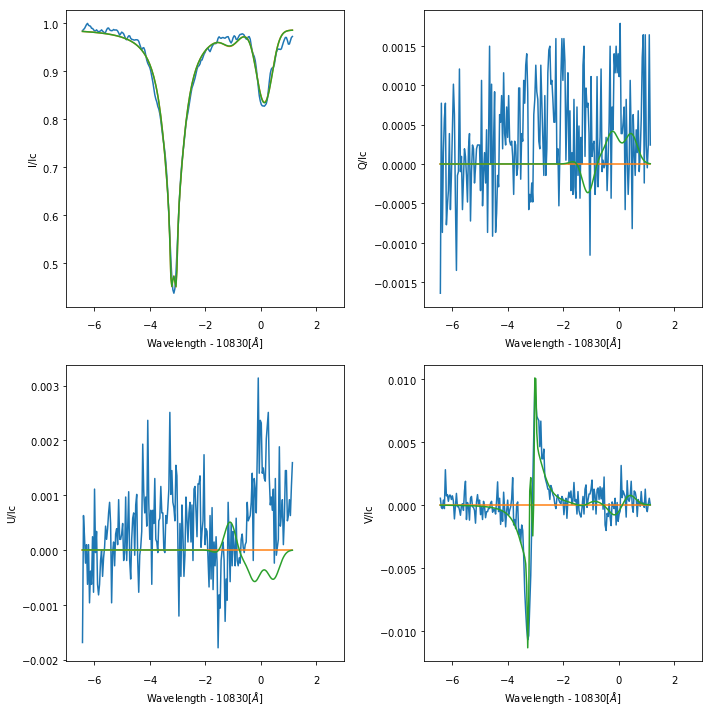

In [10]:
f = h5py.File('output.h5', 'r')

print('(npix,nrand,ncycle,nstokes,nlambda) -> {0}'.format(f['spec1']['stokes'].shape))

fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()
for i in range(4):
    ax[i].plot(f['spec1']['wavelength'][:] - 10830, stokes[i,:])
    for j in range(2):
        ax[i].plot(f['spec1']['wavelength'][:] - 10830, f['spec1']['stokes'][0,0,j,i,:])

for i in range(4):
    ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
    ax[i].set_ylabel('{0}/Ic'.format(label[i]))
    ax[i].set_xlim([-7,3])
    
#pl.tight_layout()

f.close()

Now the photospheric model:

(npix,nrand,ncycle,nz) -> (1, 1, 2, 73)


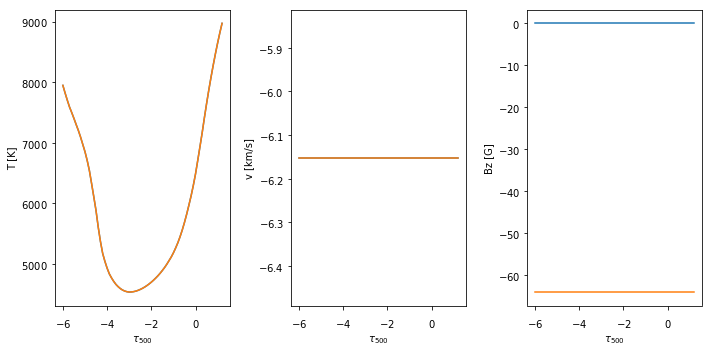

In [11]:
f = h5py.File('output.h5', 'r')

print('(npix,nrand,ncycle,nz) -> {0}'.format(f['ph1']['T'].shape))

fig, ax = pl.subplots(nrows=1, ncols=3, figsize=(10,5))
ax = ax.flatten()
for i in range(2):
    ax[0].plot(f['ph1']['log_tau'][:], f['ph1']['T'][0,0,i,:])    
    
for i in range(2):
    ax[1].plot(f['ph1']['log_tau'][:], f['ph1']['v'][0,0,i,:])
    
for i in range(2):
    ax[2].plot(f['ph1']['log_tau'][:], f['ph1']['Bz'][0,0,i,:])

ax[0].set_xlabel(r'$\tau_{500}$')
ax[0].set_ylabel('T [K]')

ax[1].set_xlabel(r'$\tau_{500}$')
ax[1].set_ylabel('v [km/s]')

ax[2].set_xlabel(r'$\tau_{500}$')
ax[2].set_ylabel('Bz [G]')
    
#pl.tight_layout()

f.close()

## Spicules
Let's try to invert observations from spicules. First, we read the observations from the datafile (already on the correct reference system and with the wavelength calibration).

dict_keys(['lambda', 'heperf', 'mask_heights'])
(25, 4, 224, 101)


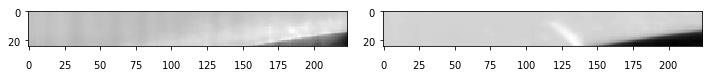

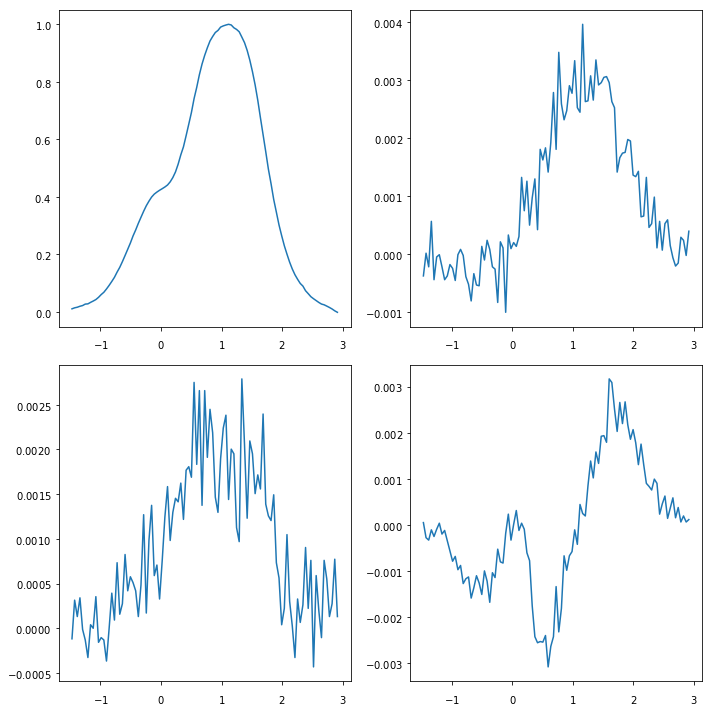

In [12]:
tmp = io.readsav('/scratch/Dropbox/test/test_hazel2/orozco/Spiculas_map.sav')
print(tmp.keys())
print(tmp['heperf'].shape)
f, ax = pl.subplots(nrows=1, ncols=2, figsize=(10,6))
ax[0].imshow(tmp['heperf'][:,0,:,0])
ax[1].imshow(tmp['heperf'][:,0,:,100])

f, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
stokes = np.zeros((4,101))
stokes[0,:] = tmp['heperf'][10,0,175,:] / np.max(tmp['heperf'][10,0,175,:])
stokes[1,:] = tmp['heperf'][10,1,175,:] / np.max(tmp['heperf'][10,0,175,:])
stokes[2,:] = tmp['heperf'][10,2,175,:] / np.max(tmp['heperf'][10,0,175,:])
stokes[3,:] = tmp['heperf'][10,3,175,:] / np.max(tmp['heperf'][10,0,175,:])
ax[0,0].plot(tmp['lambda'], stokes[0,:])
ax[0,1].plot(tmp['lambda'], stokes[1,:])
ax[1,0].plot(tmp['lambda'], stokes[2,:])
ax[1,1].plot(tmp['lambda'], stokes[3,:])

n_lambda = len(tmp['lambda'])

The first thing we do is estimate the noise standard deviation. You should do it more carefully so that the final values of the $\chi^2$ are close to one in case the observed profile can be correctly represented with the simple Hazel atmosphere. For the moment and as a quick estimation we just estimate it via the standard deviation in a small region close to the continuum.

In [13]:
noise=np.std(stokes[1,0:15])
print(noise)

0.00026189987900385165


Then we save several files with the observations. The first one the file with the wavelength axis. Remember that this axis is common to all observed pixels in case HDF5 files are used. We add 10829.0911 Angstrom because the osberved files are referred to this wavelength (it is the center of the multiplet).

In [14]:
f = hazel.tools.File_observation(mode='single')
f.set_size(n_lambda=n_lambda, n_pixel=1)
print(f.obs['stokes'].shape)
f.obs['wavelength'] = tmp['lambda']+10829.0911
f.obs['stokes'][0,:,:] = stokes.T
f.obs['sigma'] = noise*np.ones((n_lambda,4))
f.obs['los'][0,:] = np.array([90.0,0.0,90.0])
f.obs['boundary'][:] = 0.0
f.obs['weights'][:] = 1.0
f.save('10830_spicule')

(1, 101, 4)
Saving wavelength file : 10830_spicule.wavelength
Saving weights file : 10830_spicule.weights
Saving 1D Stokes file : 10830_spicule.1d


In [15]:
%cat 10830_spicule.1d

# LOS theta_LOS, phi_LOS, gamma_LOS
90.0   0.0   90.0

# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
0.0   0.0   0.0    0.0

# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV
1.065849605947732925e-02 -3.797253011725842953e-04 -1.178457823698408902e-04 5.237590085016563535e-05 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04
1.414149347692728043e-02 1.309397521254140884e-05 3.142554196529090405e-04 -2.749734849203377962e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04
1.621034182608127594e-02 -2.225975767942145467e-04 1.309397484874352813e-04 -3.273493784945458174e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04
1.961477473378181458e-02 5.630409577861428261e-04 3.404433664400130510e-04 -1.047518017003312707e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04
2.199

We print now the configuration file used in this case. Note that we do three cycles. The first one is used to estimate thermodynamical parameters from Stokes $I$. The second one is used to get information from the LOS component of the magnetic field using only Stokes $V$ (in this case the LOS lines along the X axis because $\theta=90\deg$ and $\chi=0\deg$). Finally, the third cycle gets information from Stokes $Q$ and $U$ to fix the other two components of the magnetic field. Some trial-and-error is necessary for setting up the weights. Also note that we fix the height to 3''. One should measure this number better in the observations and set it appropriately.

In [16]:
%cat conf_spicules.ini

# Hazel configuration File

[Working mode]
Output file = output.h5
Number of cycles = 3

# Topology
# Always photosphere and then chromosphere
# Photospheres are only allowed to be added with a filling factor
# Atmospheres share a filling factor if they are in parenthesis
# Atmospheres are one after the other with the -> operator
# Atmosphere 1 = ph2 -> ch1 -> ch2

[Spectral regions]
    [[Region 1]]
    Name = spec1
    #Wavelength = 10826, 10833, 150
    Topology = ch1
    Stokes weights = 1.0, 1.0, 1.0, 1.0
    LOS = 90.0, 0.0, 90.0
    Boundary condition = 0.0, 0.0, 0.0, 0.0       # I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
    Wavelength file = '10830_spicule.wavelength'
    Wavelength weight file = '10830_spicule.weights'
    Observations file = '10830_spicule.1d'    
    Weights Stokes I = 1.0, 0.1, 0.1, 0.0
    Weights Stokes Q = 0.0, 0.0, 1.0, 0.0
    Weights Stokes U = 0.0, 0.0, 1.0, 0.0
    Weights Stokes V = 0.0, 1.0, 1.0, 0.0
    Mask file = None

[Atmospheres]

    [

Let's generate an initial model more appropriate for off-limb observations:

In [17]:
tmp = hazel.tools.File_chromosphere(mode='single')
tmp.set_default(n_pixel=1, default='offlimb')
tmp.save('chromospheres/init_spicule')

Setting standard chromosphere
Saving chromospheric 1D model : chromospheres/init_spicule.1d


Finally, let's carry out the inversion. We activate some verbosity to analyze the inversion.

In [20]:
mod = hazel.Model('conf_spicules.ini', working_mode='inversion', verbose=2)
mod.read_observation()
mod.open_output()
mod.invert()
mod.write_output()
mod.close_output()

2018-10-24 09:57:09,923 - Using configuration from file : conf_spicules.ini
2018-10-24 09:57:09,925 - Adding spectral region spec1
2018-10-24 09:57:09,926 -   - Reading wavelength axis from 10830_spicule.wavelength
2018-10-24 09:57:09,928 -   - Reading wavelength weights from 10830_spicule.weights
2018-10-24 09:57:09,930 -   - Using observations from 10830_spicule.1d
2018-10-24 09:57:09,931 -   - No mask for pixels
2018-10-24 09:57:09,932 -   - No instrumental profile
2018-10-24 09:57:09,933 -   - Using LOS ['90.0', '0.0', '90.0']
2018-10-24 09:57:09,934 -   - Using off-limb normalization (peak intensity)
2018-10-24 09:57:09,935 -   - Using boundary condition ['0.0', '0.0', '0.0', '0.0']
2018-10-24 09:57:09,936 - Using 3 cycles
2018-10-24 09:57:09,937 - Not using randomizations
2018-10-24 09:57:09,937 - Adding atmospheres
2018-10-24 09:57:09,938 -   - New available chromosphere : ch1
2018-10-24 09:57:09,938 -     * Adding line : 10830
2018-10-24 09:57:09,939 -     * Magnetic field refe

After some seconds, we end up with the following fit for all cycles:

(npix,nrand,ncycle,nstokes,nlambda) -> (1, 1, 3, 4, 101)


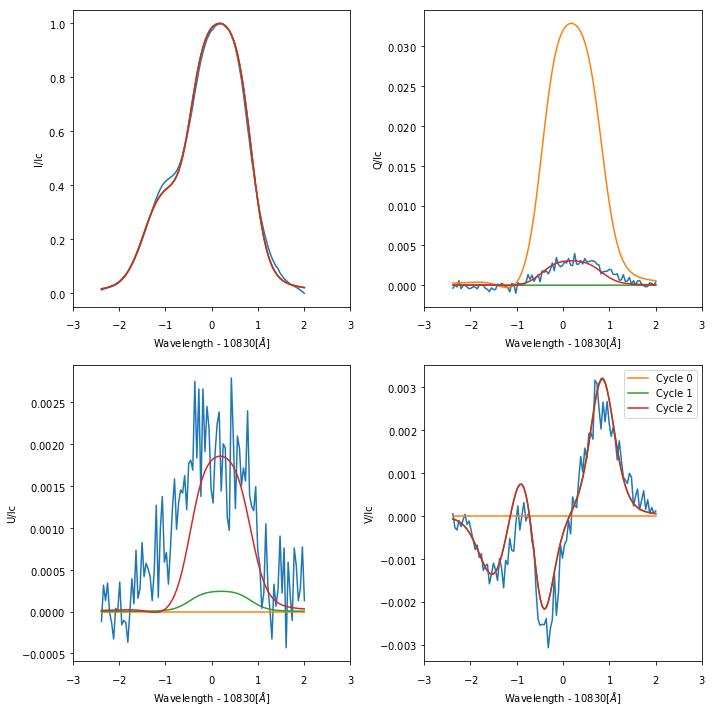

In [21]:
f = h5py.File('output.h5', 'r')

print('(npix,nrand,ncycle,nstokes,nlambda) -> {0}'.format(f['spec1']['stokes'].shape))

ncycle = f['spec1']['stokes'].shape[2]

fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()
for i in range(4):
    ax[i].plot(f['spec1']['wavelength'][:] - 10830, stokes[i,:])
    for j in range(ncycle):
        ax[i].plot(f['spec1']['wavelength'][:] - 10830, f['spec1']['stokes'][0,0,j,i,:], label='Cycle {0}'.format(j))

for i in range(4):
    ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
    ax[i].set_ylabel('{0}/Ic'.format(label[i]))
    ax[i].set_xlim([-3,3])
    
pl.legend()
#pl.tight_layout()

f.close()

## Flare
Finally, let us show how one can invert a profile from a flaring region. This profile has been kindly provided by Tetsu Anan and you can find the analysis on http://adsabs.harvard.edu/doi/10.1093/pasj/psy105. There are many things that make Hazel not be physically correct in this scenario, but let's try to check if we can fit them. Let's read the profiles and generate the appropriate files.

In [2]:
import scipy.io as io
dat = io.readsav('observations/flare.sav')
n_lambda = len(dat['wl'])
noise = np.std(dat['iquv'][1,0:5])

tmp = hazel.tools.File_observation(mode='single')
tmp.set_size(n_lambda=n_lambda, n_pixel=1)
print(tmp.obs['stokes'].shape)
tmp.obs['wavelength'] = dat['wl']
tmp.obs['stokes'][0,:,:] = dat['iquv'].T
tmp.obs['sigma'] = noise*np.ones((n_lambda,4))
tmp.obs['los'][0,:] = np.array([0.0,0.0,90.0])
tmp.obs['boundary'][:] = 0.0
tmp.obs['boundary'][0,:,0] = 1.0
tmp.obs['weights'][:] = 1.0
tmp.save('10830_flare')

(1, 81, 4)
Saving wavelength file : 10830_flare.wavelength
Saving weights file : 10830_flare.weights
Saving 1D Stokes file : 10830_flare.1d


Now we generate an initial file for the atmosphere:

In [3]:
tmp = hazel.tools.File_chromosphere(mode='single')
tmp.set_default(n_pixel=1, default='disk')
tmp.save('chromospheres/init_flare')

Setting standard chromosphere
Saving chromospheric 1D model : chromospheres/init_flare.1d


In [4]:
%cat conf_flare.ini

# Hazel configuration File

[Working mode]
Output file = output.h5
Number of cycles = 3

# Topology
# Always photosphere and then chromosphere
# Photospheres are only allowed to be added with a filling factor
# Atmospheres share a filling factor if they are in parenthesis
# Atmospheres are one after the other with the -> operator
# Atmosphere 1 = ph2 -> ch1 -> ch2

[Spectral regions]
    [[Region 1]]
    Name = spec1
    #Wavelength = 10826, 10833, 150
    Topology = ch1
    Stokes weights = 1.0, 1.0, 1.0, 1.0
    LOS = 90.0, 0.0, 90.0
    Boundary condition = 0.0, 0.0, 0.0, 0.0       # I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
    Wavelength file = '10830_flare.wavelength'
    Wavelength weight file = '10830_flare.weights'
    Observations file = '10830_flare.1d'    
    Weights Stokes I = 1.0, 0.1, 0.1, 0.0
    Weights Stokes Q = 0.0, 0.0, 1.0, 0.0
    Weights Stokes U = 0.0, 0.0, 1.0, 0.0
    Weights Stokes V = 0.0, 1.0, 0.1, 0.0
    Mask file = None

[Atmospheres]

    [[Chrom

And carry out the inversion in two cycles:

In [5]:
mod = hazel.Model('conf_flare.ini', working_mode='inversion', verbose=3)
mod.read_observation()
mod.open_output()
mod.invert()
mod.write_output()
mod.close_output()

2018-11-05 09:59:10,915 - Using configuration from file : conf_flare.ini
2018-11-05 09:59:10,918 - Backtracking mode : brent
2018-11-05 09:59:10,919 - Adding spectral region spec1
2018-11-05 09:59:10,920 -   - Reading wavelength axis from 10830_flare.wavelength
2018-11-05 09:59:10,922 -   - Reading wavelength weights from 10830_flare.weights
2018-11-05 09:59:10,924 -   - Using observations from 10830_flare.1d
2018-11-05 09:59:10,925 -   - No mask for pixels
2018-11-05 09:59:10,926 -   - No instrumental profile
2018-11-05 09:59:10,927 -   - Using LOS ['90.0', '0.0', '90.0']
2018-11-05 09:59:10,928 -   - Using off-limb normalization (peak intensity)
2018-11-05 09:59:10,928 -   - Using boundary condition ['0.0', '0.0', '0.0', '0.0']
2018-11-05 09:59:10,929 - Using 3 cycles
2018-11-05 09:59:10,930 - Not using randomizations
2018-11-05 09:59:10,930 - Adding atmospheres
2018-11-05 09:59:10,931 -   - New available chromosphere : ch1
2018-11-05 09:59:10,932 -     * Adding line : 10830
2018-11-

     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.430    -0.425     7.307     1.161     0.000


2018-11-05 09:59:13,001 -   * Optimal lambda: 0.08247935252073106
2018-11-05 09:59:13,365 - It: 1 - chi2: 20556.398483588408 - lambda: 0.08247935252073106 - rel: -0.9196758185036208


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.203    -1.226     6.511     1.539     0.000


2018-11-05 09:59:14,090 -   * Optimal lambda: 0.0661751348188397
2018-11-05 09:59:14,456 - It: 2 - chi2: 10943.3347365054 - lambda: 0.0661751348188397 - rel: -0.6103584230326621


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.083    -2.718     6.192     2.271     0.000


2018-11-05 09:59:14,689 -   * Optimal lambda: 0.0015838233632373328
2018-11-05 09:59:14,986 - It: 3 - chi2: 7071.840045349796 - lambda: 0.0015838233632373328 - rel: -0.4298037335785336


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.203    -6.520     6.071     3.266     0.000


2018-11-05 09:59:15,211 -   * Optimal lambda: 0.024342561318410814
2018-11-05 09:59:15,500 - It: 4 - chi2: 5298.779563758542 - lambda: 0.024342561318410814 - rel: -0.2866566975005473


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.259    -2.718     6.192     3.474     0.000


2018-11-05 09:59:16,199 -   * Optimal lambda: 2.676100841671796
2018-11-05 09:59:16,547 - It: 5 - chi2: 4997.289225073743 - lambda: 2.676100841671796 - rel: -0.05856416557974302


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.259    -2.311     6.511     3.468     0.000


2018-11-05 09:59:17,197 -   * Optimal lambda: 1.494491984209709
2018-11-05 09:59:17,571 - It: 6 - chi2: 4344.583429256352 - lambda: 1.494491984209709 - rel: -0.1397376778658725


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.256    -1.661     7.307     3.456     0.000


2018-11-05 09:59:18,326 -   * Optimal lambda: 1.1240217523954015
2018-11-05 09:59:18,693 - It: 7 - chi2: 3103.2729058139976 - lambda: 1.1240217523954015 - rel: -0.33333363792136833


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.255    -0.671     9.061     3.445     0.000


2018-11-05 09:59:19,407 -   * Optimal lambda: 0.47134769774538293
2018-11-05 09:59:19,765 - It: 8 - chi2: 1687.1669851286654 - lambda: 0.47134769774538293 - rel: -0.5912216635314762


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.257     1.212    12.048     3.441     0.000


2018-11-05 09:59:20,472 -   * Optimal lambda: 0.6162592434715304
2018-11-05 09:59:20,757 - It: 9 - chi2: 1360.4395587871902 - lambda: 0.6162592434715304 - rel: -0.21441575323674467


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.272     2.476    13.277     3.480     0.000


2018-11-05 09:59:21,479 -   * Optimal lambda: 1.8197967977297405
2018-11-05 09:59:21,757 - It: 10 - chi2: 1349.1810119214601 - lambda: 1.8197967977297405 - rel: -0.008310054173219986


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.274     2.695    13.250     3.488     0.000


2018-11-05 09:59:22,457 -   * Optimal lambda: 2.720041425720803
2018-11-05 09:59:22,841 - It: 11 - chi2: 1344.0065367793868 - lambda: 2.720041425720803 - rel: -0.0038426400304497343


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.275     2.797    13.184     3.490     0.000


2018-11-05 09:59:23,201 - -------------
2018-11-05 09:59:23,202 -   Cycle 1  
2018-11-05 09:59:23,202 -   Weights for region spec1 : SI=0.1 - SQ=0.0 - SU=0.0 - SV=1.0
2018-11-05 09:59:23,203 - -------------
2018-11-05 09:59:23,204 - Free parameters for ch1
2018-11-05 09:59:23,205 -   - Bz with 1 node
2018-11-05 09:59:24,113 -   * Optimal lambda: 0.00030736492625848606
2018-11-05 09:59:24,184 - It: 0 - chi2: 260.4803659733832 - lambda: 0.00030736492625848606 - rel: -1.3506201502137916


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000  1729.585     0.275     2.797    13.184     3.490     0.000


2018-11-05 09:59:24,905 -   * Optimal lambda: 0.023925353436515272
2018-11-05 09:59:24,975 - It: 1 - chi2: 252.34132580274837 - lambda: 0.023925353436515272 - rel: -0.031742183691355445


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000  1966.275     0.275     2.797    13.184     3.490     0.000


2018-11-05 09:59:25,703 -   * Optimal lambda: 249.3304218316581
2018-11-05 09:59:25,846 - It: 2 - chi2: 252.34131886461535 - lambda: 249.3304218316581 - rel: -2.749503316444333e-08


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000  1966.274     0.275     2.797    13.184     3.490     0.000


2018-11-05 09:59:25,987 - -------------
2018-11-05 09:59:25,988 -   Cycle 2  
2018-11-05 09:59:25,989 -   Weights for region spec1 : SI=0.1 - SQ=1.0 - SU=1.0 - SV=0.1
2018-11-05 09:59:25,990 - -------------
2018-11-05 09:59:25,991 - Free parameters for ch1
2018-11-05 09:59:25,992 -   - Bx with 1 node
2018-11-05 09:59:25,993 -   - By with 1 node
2018-11-05 09:59:26,347 -   * Optimal lambda: 9.479695446674016
2018-11-05 09:59:26,484 - It: 0 - chi2: 167.14874325448315 - lambda: 9.479695446674016 - rel: -0.4061720803576269


     Bx        By        Bz        tau       v       deltav      beta      a
 924.234   932.081  1948.851     0.275     2.797    13.184     3.490     0.000


2018-11-05 09:59:27,182 -   * Optimal lambda: 0.27653309758863565
2018-11-05 09:59:27,327 - It: 1 - chi2: 159.19817147732678 - lambda: 0.27653309758863565 - rel: -0.048724663345998565


     Bx        By        Bz        tau       v       deltav      beta      a
 136.564   506.619  1948.851     0.275     2.797    13.184     3.490     0.000


2018-11-05 09:59:28,030 -   * Optimal lambda: 0.2458829348400783
2018-11-05 09:59:28,264 - It: 2 - chi2: 158.94549989550788 - lambda: 0.2458829348400783 - rel: -0.0015884118060786087


     Bx        By        Bz        tau       v       deltav      beta      a
  48.422   630.237  1948.851     0.275     2.797    13.184     3.490     0.000


2018-11-05 09:59:28,963 -   * Optimal lambda: 0.08871830958767633
2018-11-05 09:59:29,190 - It: 3 - chi2: 158.94439473845108 - lambda: 0.08871830958767633 - rel: -6.953080770756462e-06


     Bx        By        Bz        tau       v       deltav      beta      a
  56.350   636.338  1948.851     0.275     2.797    13.184     3.490     0.000


(npix,nrand,ncycle,nstokes,nlambda) -> (1, 1, 3, 4, 81)


/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


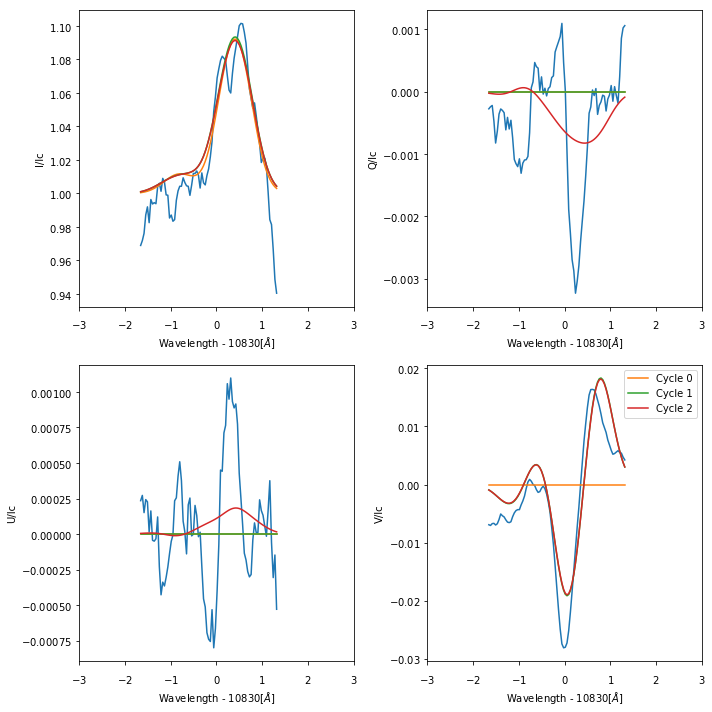

In [6]:
f = h5py.File('output.h5', 'r')

print('(npix,nrand,ncycle,nstokes,nlambda) -> {0}'.format(f['spec1']['stokes'].shape))

ncycle = f['spec1']['stokes'].shape[2]

fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()
for i in range(4):
    ax[i].plot(f['spec1']['wavelength'][:] - 10830, dat['iquv'][i,:])
    for j in range(ncycle):
        ax[i].plot(f['spec1']['wavelength'][:] - 10830, f['spec1']['stokes'][0,0,j,i,:], label='Cycle {0}'.format(j))

for i in range(4):
    ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
    ax[i].set_ylabel('{0}/Ic'.format(label[i]))
    ax[i].set_xlim([-3,3])
    
pl.legend()
#pl.tight_layout()

f.close()